In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
# 数据
transform = transforms.Compose([
    transforms.ToTensor(),
])

data_dir = r"D:\cc\Desktop\data"

train_dataset = datasets.MNIST(root=data_dir, train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_dataset = datasets.MNIST(root=data_dir, train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [3]:
# 定义主VAE
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4_mu = nn.Linear(hidden_dim, input_dim)
        self.fc4_logvar = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc2_mu(h), self.fc2_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return self.fc4_mu(h), self.fc4_logvar(h)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28 * 28))
        z = self.reparameterize(mu, logvar)
        recon_mu, recon_logvar = self.decode(z)
        return recon_mu, recon_logvar, mu, logvar

# 残差 VAE
class ResidualVAE(nn.Module):
    def __init__(self, input_dim, cond_dim, hidden_dim, latent_dim):
        super(ResidualVAE, self).__init__()
        self.fc1 = nn.Linear(input_dim + cond_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim + cond_dim, hidden_dim)
        self.fc4_mu = nn.Linear(hidden_dim, input_dim)
        self.fc4_logvar = nn.Linear(hidden_dim, input_dim)

    def encode(self, d, x_prime):
        h = torch.relu(self.fc1(torch.cat([d, x_prime], dim=1)))
        return self.fc2_mu(h), self.fc2_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, x_prime):
        h = torch.relu(self.fc3(torch.cat([z, x_prime], dim=1)))
        return self.fc4_mu(h), self.fc4_logvar(h)

    def forward(self, d, x_prime):
        mu, logvar = self.encode(d, x_prime)
        z = self.reparameterize(mu, logvar)
        recon_mu, recon_logvar = self.decode(z, x_prime)
        return recon_mu, recon_logvar, mu, logvar

# 参数设置
input_dim = 28 * 28
hidden_dim = 400  
latent_dim = 20
num_epochs = 10 

In [4]:
# 初始化模型
model_vae1 = VAE(input_dim, hidden_dim, latent_dim)
model_vae2 = ResidualVAE(input_dim, input_dim, hidden_dim, latent_dim)
optimizer_vae1 = optim.Adam(model_vae1.parameters(), lr=1e-4)
optimizer_vae2 = optim.Adam(model_vae2.parameters(), lr=1e-4)

# 损失函数
def loss_function(recon_mu, recon_logvar, x, mu, logvar):
    recon_loss = -0.5 * torch.sum(
        1 + recon_logvar - (x - recon_mu).pow(2) - recon_logvar.exp()
    )
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_divergence

# 训练主 VAE
for epoch in range(num_epochs):
    model_vae1.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.view(-1, 784)
        optimizer_vae1.zero_grad()
        recon_mu, recon_logvar, mu, logvar = model_vae1(data)
        loss = loss_function(recon_mu, recon_logvar, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer_vae1.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss / len(train_loader.dataset):.4f}')

Epoch [1/10], Loss: 29.8967
Epoch [2/10], Loss: 24.0815
Epoch [3/10], Loss: 22.8543
Epoch [4/10], Loss: 22.2511
Epoch [5/10], Loss: 21.8523
Epoch [6/10], Loss: 21.5857
Epoch [7/10], Loss: 21.3840
Epoch [8/10], Loss: 21.2206
Epoch [9/10], Loss: 21.1101
Epoch [10/10], Loss: 21.0071


In [5]:
# 准备残差数据
model_vae1.eval()
residuals = []
x_primes = []

with torch.no_grad():
    for data, _ in train_loader:
        data = data.view(-1, 784) 
        recon_mu, recon_logvar, _, _ = model_vae1(data)
        x_prime = recon_mu
        d = data - x_prime
        residuals.append(d)
        x_primes.append(x_prime)

residuals = torch.cat(residuals)
x_primes = torch.cat(x_primes)
residual_dataset = torch.utils.data.TensorDataset(residuals, x_primes)
residual_loader = torch.utils.data.DataLoader(residual_dataset, batch_size=64, shuffle=True)

# 训练残差 VAE
for epoch in range(num_epochs):
    model_vae2.train()
    train_loss = 0
    for d_batch, x_prime_batch in residual_loader:
        optimizer_vae2.zero_grad()
        recon_mu, recon_logvar, mu, logvar = model_vae2(d_batch, x_prime_batch)
        loss = loss_function(recon_mu, recon_logvar, d_batch, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer_vae2.step()
    print(f'Residual VAE Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss / len(residual_loader.dataset):.4f}')

Residual VAE Epoch [1/10], Loss: 15.6180
Residual VAE Epoch [2/10], Loss: 15.4935
Residual VAE Epoch [3/10], Loss: 15.4220
Residual VAE Epoch [4/10], Loss: 15.3392
Residual VAE Epoch [5/10], Loss: 15.2612
Residual VAE Epoch [6/10], Loss: 15.1895
Residual VAE Epoch [7/10], Loss: 15.1313
Residual VAE Epoch [8/10], Loss: 15.0835
Residual VAE Epoch [9/10], Loss: 15.0394
Residual VAE Epoch [10/10], Loss: 15.0016


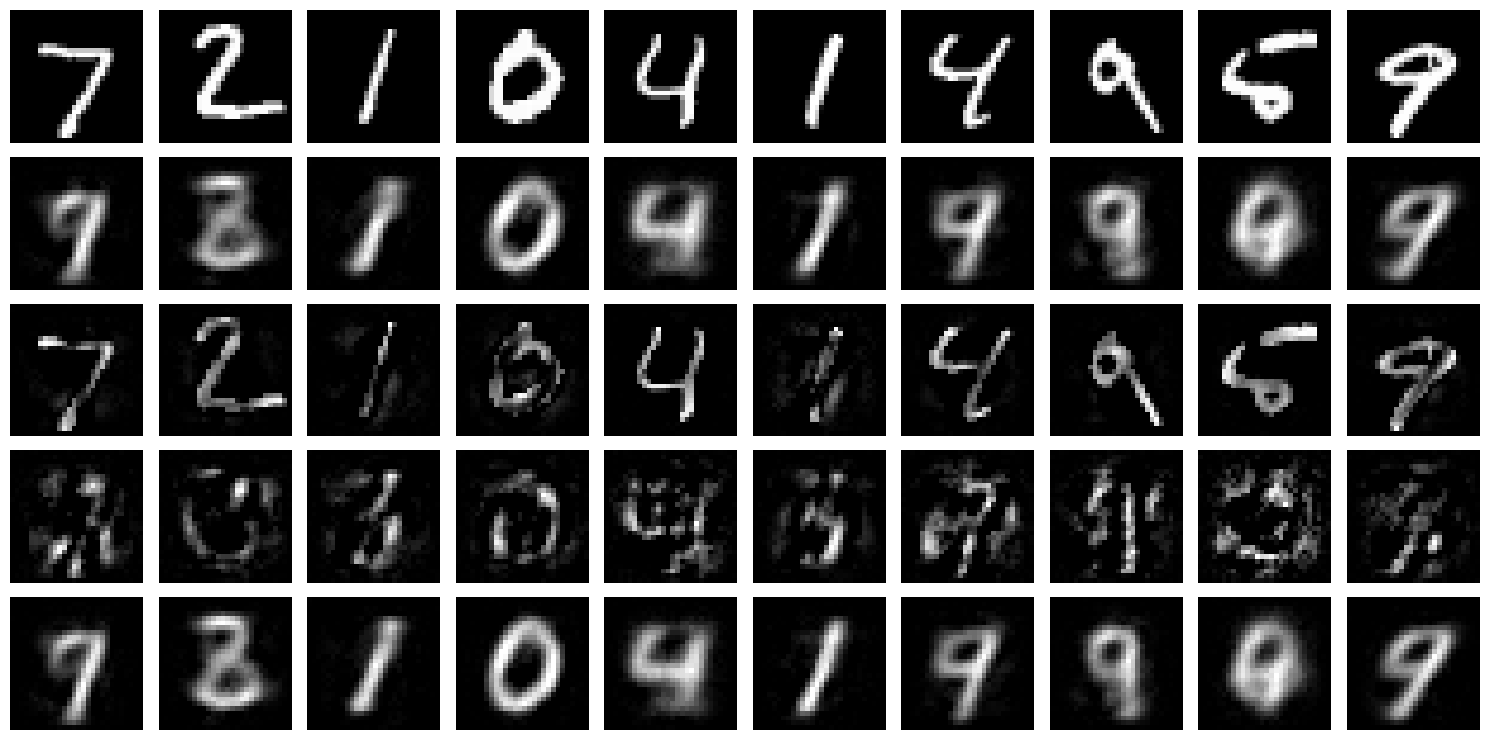

In [6]:
# 可视化

model_vae1.eval()
model_vae2.eval()

with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data[:10].view(-1, 784)
    x_prime, _, _, _ = model_vae1(data)
    d = data - x_prime
    d_prime, _, _, _ = model_vae2(d, x_prime)
    x_final = x_prime + d_prime

    # 裁剪输出
    x_prime = torch.clamp(x_prime, 0, 1)
    d = torch.clamp(d, 0, 1)
    d_prime = torch.clamp(d_prime, 0, 1)
    x_final = torch.clamp(x_final, 0, 1)

    data_img = data.view(-1, 1, 28, 28)
    x_prime_img = x_prime.view(-1, 1, 28, 28)
    d_img = d.view(-1, 1, 28, 28)
    d_prime_img = d_prime.view(-1, 1, 28, 28)
    x_final_img = x_final.view(-1, 1, 28, 28)

    fig, axes = plt.subplots(5, 10, figsize=(15, 7.5))
    for i in range(10):
        axes[0, i].imshow(data_img[i][0], cmap='gray')
        axes[1, i].imshow(x_prime_img[i][0], cmap='gray')
        axes[2, i].imshow(d_img[i][0], cmap='gray')  # 移除了 vmin/vmax
        axes[3, i].imshow(d_prime_img[i][0], cmap='gray')
        axes[4, i].imshow(x_final_img[i][0], cmap='gray')
        for ax in axes[:, i]:
            ax.axis('off')

    axes[0, 0].set_ylabel('Original', fontsize=10)
    axes[1, 0].set_ylabel("X'", fontsize=10)
    axes[2, 0].set_ylabel('D', fontsize=10)
    axes[3, 0].set_ylabel("D'", fontsize=10)
    axes[4, 0].set_ylabel("X'+D'", fontsize=10)

    plt.tight_layout()
    plt.show()